# Dimensionality Reduction

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## The Curse of Dimensionality

Datasets with **high dimensionality** (_many features_) cause the risk of the data set being _too sparse_. It means that each training instance tends to be too far apart from each other. This makes **predictions less reliable than in lower dimensions**, since they have to be extrapolated more. In other words, _many dimensions cause a greater risk of overfitting_.

Although a possible solution is to increase the number of instances, having a data set with, for example, 100 features would require training instances of about the number close to the number of atoms in the universe.

## Main Approaches for Dimensionality Reduction

There are two mains approaches to reduce the dimensionality: **Projection** and **Manifold Learning**.

### Projection

When using real-world data, instances are not evenly spread across the dataset. Many of the features are either evenly spread or highly correlated.

This results in training instances in a higher-dimensional space being **closer to a lower-dimensional subspace plotted on a plane**.

This allows, for example, a 3D dimension (such as $x_{1}$, $x_{2}$, and $x_{3}$) to 2D dimensions (such as $z_{1}$ and $z_{2}$).

In [10]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

AttributeError: module 'matplotlib.cbook' has no attribute '_broadcast_with_masks'

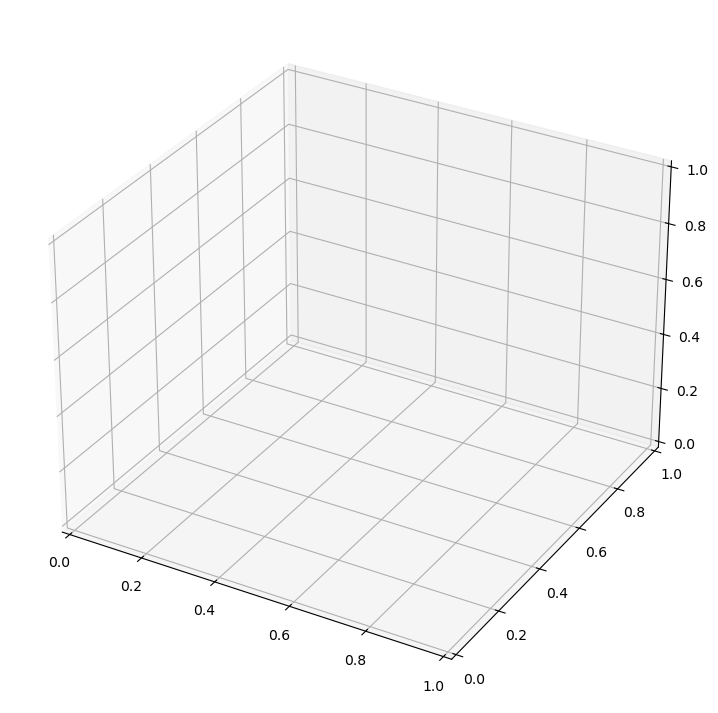

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot", tight_layout=False)
plt.show()

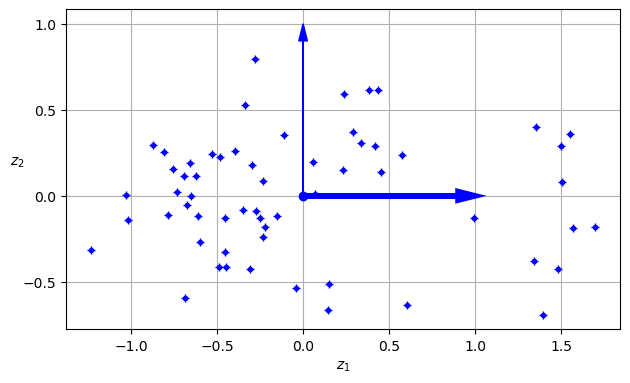

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
save_fig("dataset_2d_plot")

### Manifold Learning

Some projections can be more challenging, such as the _Swiss Roll_, which is an example of a 2D _Manifold_. This type of figure can be interpreted as something that would fit into a 2D plane, but when "rolled up" it becomes a 3D figure. In more technical terms, a d-dimensional _Manifold_ is part of an n-dimensional space (d < n).

In [27]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

AttributeError: module 'matplotlib.cbook' has no attribute '_broadcast_with_masks'

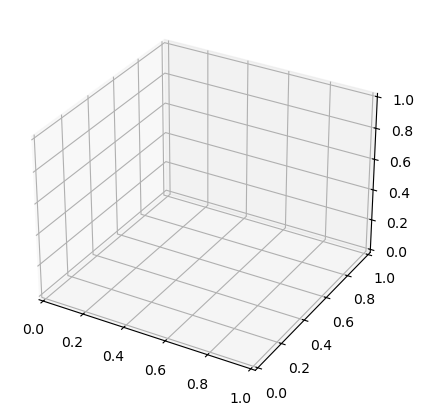

In [29]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
save_fig("swiss_roll_plot")
plt.show()

AttributeError: module 'matplotlib.cbook' has no attribute '_broadcast_with_masks'

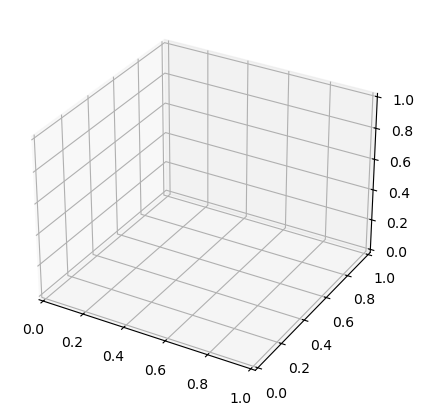

In [31]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
plt.show()

If you try to project it, you will end up with a "flattened" figure with no discernible or interpretable results.

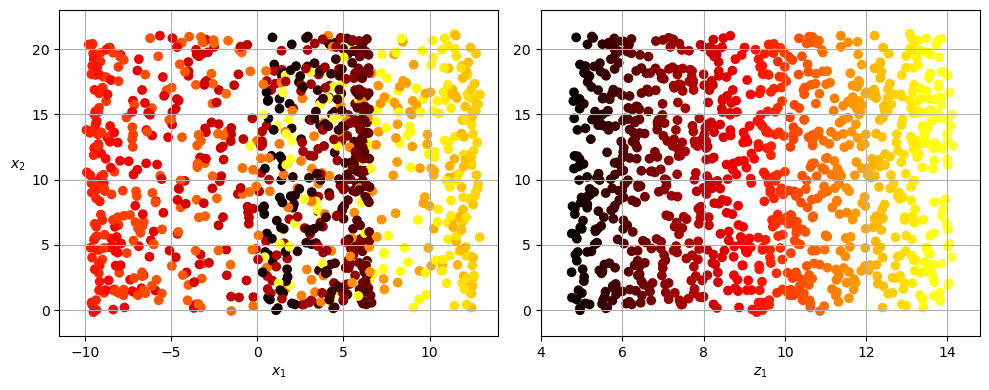

In [21]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

The **Manifold Hypothess** postulates that most high-dimensional data sets in the real world are similar to a Manifold of much lower dimension. That hypothesis also take as implicit that, the lower dimention will be simpler than a non-lower dimention of the _Manifold_, which _will make the alghorithm faster_, but depending of the training set, the _performance could be or not better_.

Below we can see examples of how the _Decision Boundaries_ could make the visualization and model better or not:

AttributeError: module 'matplotlib.cbook' has no attribute '_broadcast_with_masks'

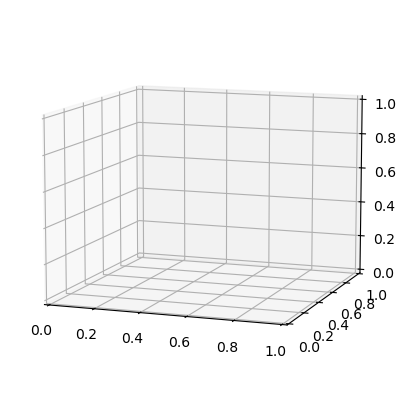

In [53]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot2")
plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot4")
plt.show()

## PCA

**Principal Component Analysis** (PCA) identifies the closest hiperplane to the data and projectthe data in the hiperplane.

### Preserving the Variance

There are two things that we should analyze mainly when using the hyperplane selection:

- Preserve the maximum variance
- Minimize the mean squared distance between the original dataset and the projection.

Below we see the example where the solid line preserves the maximum variance, the dashed line preserves an average quantity and the dotted line a minimum quantity:

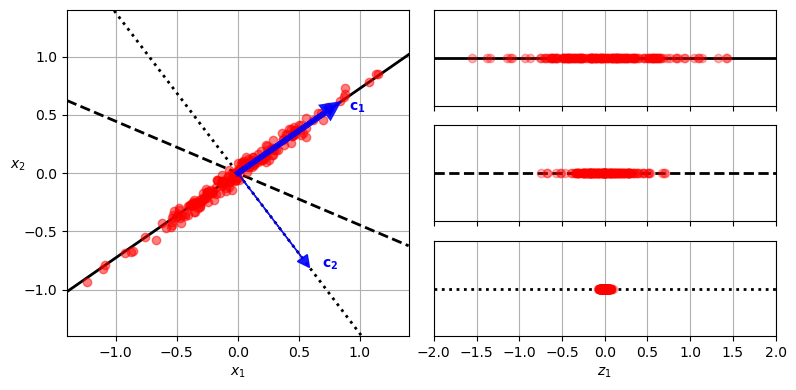

In [58]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

save_fig("pca_best_projection_plot")
plt.show()

### Principal Components

PCA identifies which axis preserves the greatest variance along with another orthogonal axis that has the most remaining variance. For this example we used two axes, but the same could have been done for larger numbers of dimensions.

Each of these axes is called a _Principal Component_. For the previous example, the two Principal Components (PCs) formed the hyperplane. This is done through a matrix factorization technique called _Singular Value Decomposition_ (SVD) that decomposes the matrix **X** into three others, using the equation $X = U \Sigma V^{T}$ where **V** contains the vectors that define the PCs.

You can use `NumPy` to perform this decomposition:

In [63]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [65]:
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

### Projecting Down to d Dimensions

To project the reduction of dimensions from n (number of current features) to d (number of desired dimensions), a hyperplane with the first d PCs is selected, in order to preserve the greatest possible amount of variance.

An equation that demonstrates the projection is shown below, where $X$ is the original matrix, $W_{d}$ is the matrix of V containing the first d columns and $X_{d-proj}$ is the reduced matrix.

$$
X_{d-proj} = X W_{d}
$$


In [76]:
W2 = Vt[:2].T
X2D = X_centered @ W2

### Using Scikit-Learn

Scikit-Learn performs the process automatically using the `PCA` class, requiring the adjustment of hyperparameters such as `n_components`.

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

If you want to see the matrix $W_{d}$, you can do so using the `components_attribute` method.

In [80]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

### Explained Variance Ratio

You can view the variance rate preserved in each selected PC using the `explained_variance_ratio` variable. Below we can see an example:

In [82]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

It is observed that the first PC preserved about 76% of the variance, and the second PC about 15%, maintaining a variance of more than 90%.

### Choosing the Right Number of Dimensions

For most cases, around 95% variance preserved is a good value. Below we will use the MNIST set as an example for this, where the d variable will hold the dimensions:

In [85]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(d)

154


A second option, in a simpler way, it is possible to do this in the `n_components` hyperparameter by using a float value between 0.0 and 1.0 instead of an int:

In [89]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_

154

In [93]:
pca.explained_variance_ratio_.sum()

0.9501960192613035

A third option is ot make a plot of the variance and the dimensions. We can se that in the elbow, the projection starts to loss less variance:

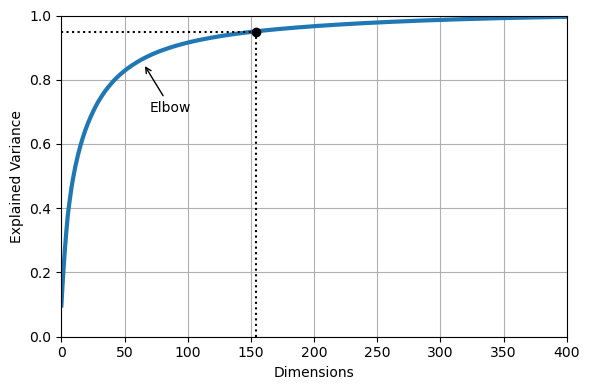

In [95]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [109]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 475, 'pca__n_components': 57}


As a fourth and final option, it is possible to tune the parameters during supervised learning. Below we see an example of a `PCA` followed by a `RandomForestClassification`:

It is interesting to note that if a linear whole were used, such as `SGD`, more dimensions would be needed to make a more concise model:

In [111]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [112]:
grid_search.best_params_

{'pca__n_components': 67}

### PCA for Compression

Analyzing the compression performed, 95% of the variance was maintained using only 154 features (less than 20% of the original size, 784).

It is possible to perform a decompression to return the 784 dimensions by applying an inverse transformation, which will not give the original data (5% variance was lost), but will be very close. To do this, the equation $X_{recovered} = X_{d-proj} W_{d}^{T}$ is used, or the `inverse_transform()` method:

In [116]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [118]:
X_recovered = pca.inverse_transform(X_reduced)

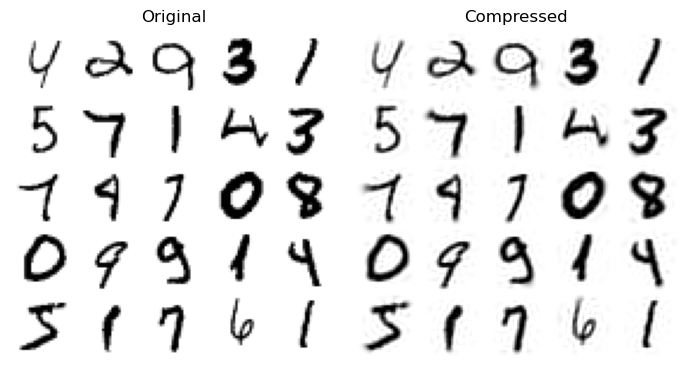

In [124]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("mnist_compression_plot")

## Randomized PCA

When we set the hyperparameter `svd_solver = "randomized"`, the _Randomized PCA_ is used, which is much faster in its execution, as it operates in a computational complexity dependent on d, and no longer on n (considering that d << n):

In [132]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

The **Incremental PCA** (IPCA) algorithm divides the training set into **mini-batches** and increases the algorithm with one mini-batch at a time. It's highly recomended for online trainig or incremental data.

An example below will be using 100 mini-batches for the MNIST set. We can use either `IncrementalPCA` or `NumPy` and `memmap`:

In [137]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [138]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

In [139]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

## Random Projection

The method uses a random projection into a lower-dimensional space, causing similar instances to remain similar and very different instances to remain very different. As with all forms of reduction, the more dimensions are discarded, the more information is lost and the more instances are distorted.

For this method, it is not necessary to know how many n features there are, but rather how many m instances there are and the tolerance value $\varepsilon $ that determines the tolerable value of squared distance between two instances. You can use the class `johnson_lindenstrauss_min_dim` to obtain the mininum dimension:

In [148]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

In [150]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T

In [153]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

There is also a second transformer in this library, `SparseRandomProjection`, which uses less memory, is faster and has comparable quality.

In [155]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [156]:
# extra code – performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
3.32 s ± 60.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
2.24 s ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
8.69 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
4.34 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In short, **Random Projection** is a simple, fast and memory-efficient method useful for dimensionality reduction.

## LLE

**Locally Linear Embedding** or **LLE** is a Nonlinear Dimensionality Reduction or NLDR, which, unlike the other techniques discussed in the chapter, does not rely on projection. First, LLE measure how each instance relates to its neighbors. Then it looks for low-dimensional representation of the training set where each local relationship is best preserved.

In [170]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

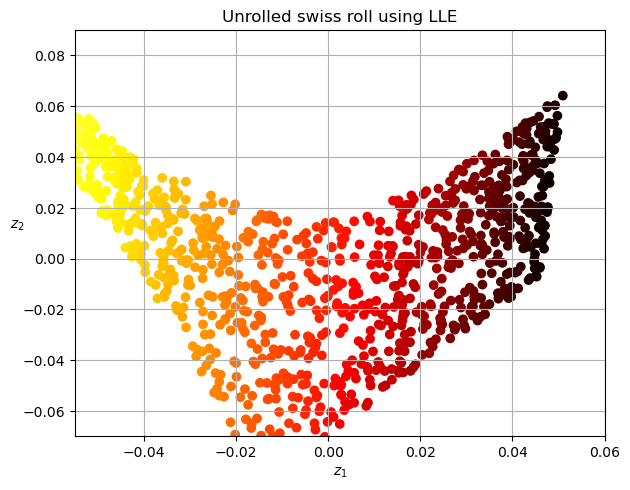

In [172]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()

The LLE model is better able to build models in low-dimensional representations, especially in nonlinear data.

## Other Dimensionality Reduction Techniques

Other dimensionality reduction methods in the Scikit-Learn library are:

- **Multidimensional Scaling** (MDS): Tries to preserve distance between instances. Comparable to _Random Projection_, but when this is better for many data, MDS is better for low-dimensional data. ` sklearn.manifold.MDS`.

- **Isomap**: Operates by creating a graph that connects instances to their closest neighbors and performs the reduction by trying to reduce the _Geodesic Discance_ of the instances (shortest path between two _nodes_). `sklearn.manifold.Isomap`

- **T-Distributed Stochastic Neighbor Embedding** (t-SNE): Tries to keep similar instances close and dissimilar instances far apart. Operates best for visualizing clusters. `sklearn.manifold.TSNE`

- **Linear Discriminat Analysis** (LDA): Operates with linear classification, where it learns the most discriminative axes of the classes to determine the hyperplanes. It distances the classes from each other and is useful before executing classification algorithms.  `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`

In [162]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [163]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [164]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

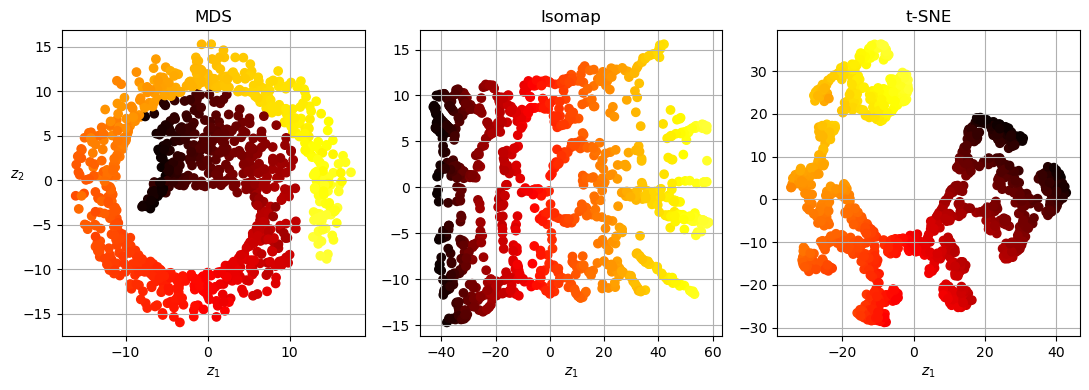

In [165]:
# extra code – this cell generates and saves Figure 8–11

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()